In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from PIL import Image, ImageSequence
import glob
import os
import re

credit: @pmocz https://github.com/pmocz/nbody-python/blob/master/nbody.py

The first thing we need to do is define all the physics that is going on under the hood. The main thing we will be using for this is Newton's Law of Universal Gravitation (assuming no relativistic effects due to extreme speeds or densities). The net force on any particular body is the sum of the gravitational forces from all the other bodies pulling on it, so we can use this to calculate the accelerations, velocities, and positions as a function of time. This will allow us to then take a snapshot at a particular time, then time step and take another snapshot, repeating until the simulation ends. For very close approaches, where the gravitational force will increase to near infinity due to the very small separation distance, we will also implement a softening length that fixes the maximum gravitational force to be a constant.

In [2]:
# the first thing we need is to define a function that accepts positions, masses, and constants, and calculates the acceleration on each body.

def get_accel(pos, mass, G, softening):

# pos is an N x 3 matrix of position (x,y,z) for each of the N bodies in the simulation at a particular time
# mass is an N x 1 vector of masses for each of the N bodies
# G and softening_length are Newton's gravity constant and the value used to "smooth out" the gravitational force, respectively

    # positions
    x = pos[:, 0:1]    # returns the first column of pos, the x values
    y = pos[:, 1:2]    # returns the second column of pos, the y values
    z = pos[:, 2:3]    # returns the third column of pos, the z values

    # pairwise particle separations
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # applying the inverse square law
    inv_r3 = (dx**2 +  dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0] ** (-1.5)

    # calculating accelerations: ma = GMm/r^2, so a = GM/r^2 
    a_x = G * (dx * inv_r3) @ mass
    a_y = G * (dy * inv_r3) @ mass
    a_z = G *(dz * inv_r3) @ mass

    # putting the components together
    a = np.hstack((a_x, a_y, a_z))

    # return the acceleration for use in other calculations
    return a

# now let's calculate KE and PE of the system
def get_energy(pos, vel, mass, G):

# pos is an N x 3 matrix of position (x,y,z) like before
# vel is an N x 3 matrix of velocities(v_x, v_y, v_z) for each body at a particular time
# mass is an N x 1 matrix of masses like before
# G is Newton's gravitational constant

    # calculate kinetic energy
    KE = 0.5 * np.sum(np.sum(mass * vel**2))

    # positions
    x = pos[:, 0:1]
    y = pos[:, 1:2]
    z = pos[:, 2:3]

    # pairwise particle separations
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    # calculate potential energy, U = -GMm/r
    inv_r = np.sqrt(dx**2 + dy**2 + dz**2)
    inv_r[inv_r > 0] = 1.0 / inv_r[inv_r > 0]

    # sum over upper triangle of the matrix to prevent double counting interactions
    PE = G * np.sum(np.sum(np.triu(-(mass * mass.T) * inv_r, 1)))

    return KE, PE

Now that the physics has been defined, let's input the actual parameters of the simulation and show how all the functions interact!

In [3]:
# taken from Google AI

def generate_disk_points(num_points, disk_radius):
    r_rand = np.random.rand(num_points)
    r = disk_radius * np.sqrt(r_rand)
    theta = 2 * np.pi * np.random.rand(num_points)

    firstx = r * np.cos(theta)
    firsty = r * np.sin(theta)

    finalx = np.append(firstx, 0.0)
    finaly = np.append(firsty, 0.0)
    finalz = np.zeros(len(firstx)+1)

    zipped_output = zip(finalx, finaly, finalz)
    result_list = list(zipped_output)
    xyz_list = np.array([list(triple) for triple in result_list])

    return xyz_list

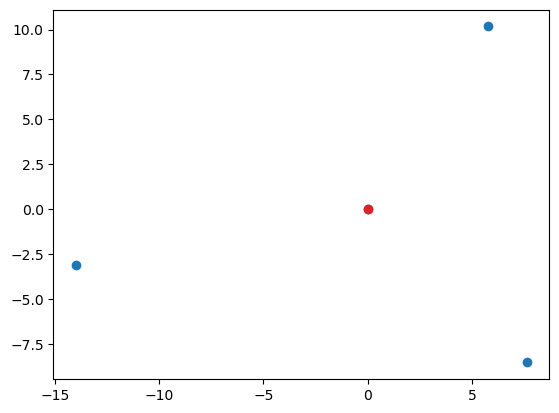

In [4]:
bodies = 4
radius = 20
results = generate_disk_points(bodies-1, radius)
plt.scatter(results[:,0], results[:,1], color = "tab:blue")
plt.scatter(results[:,0][-1], results[:,1][-1], color = "tab:red")

In [24]:
# work out how to unify the random disk creation code with the rest of it

def main():
    
    # defining constants
    t = 0
    t_end = 250
    dt = 0.1
    softening_length = 1.0
    G = 1
    plotRealTime = True

    plotlen = 100

    np.random.seed(2025)   # setting a random number seed for repeatable results

    # if you want uniform masses and random initial positions
    #mass = 20 * (np.ones((N_bodies, 1)) / N_bodies)   # total mass of 20
    #pos = 3*np.random.randn(N_bodies, 3)   # random position from 0 to 1 for each x, y, z
    #vel = 0*np.random.randn(N_bodies, 3)   # random velocity from 0 to 1 for each v_x, v_y, v_z

    # if you want specific control over the masses, positions, velocities
    
    # creating bodies:
    N_bodies = 300
    disk_radius = 0.67*plotlen
    pos_results = generate_disk_points(N_bodies-1, disk_radius)
    testmass = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 100]).reshape(-1, 1)
    #mass = np.array([1.1, 1.32, 1.54, 1.63, 1.1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]).reshape(-1, 1)
    
    mass = testmass
    pos = pos_results
    vel = 0*np.random.randn(N_bodies, 3)

    
    # converting to COM frame
    vel -= (np.mean(mass * vel, 0) / np.mean(mass))

    # calculate initial gravitational accelerations
    acc = get_accel(pos, mass, G, softening_length)

    # calculate initial KE and PE of the system
    KE, PE = get_energy(pos, vel, mass, G)

    # number of timesteps
    N_steps = int(np.ceil(t_end / dt))

    # save energies, particle orbits for plotting trails
    save_pos = np.zeros((N_bodies, 3, N_steps + 1))
    save_pos[:, :, 0] = pos
    save_KE = np.zeros(N_steps + 1)
    save_KE[0] = KE
    save_PE = np.zeros(N_steps + 1)
    save_PE[0] = PE
    t_all = np.arange(N_steps + 1) * dt

    # prep figure
    fig, ax1 = plt.subplots(figsize = (7.5, 7.5))
    #grid = plt.GridSpec(3, 1, wspace = 0.0, hspace = 0.3)
    #ax1 = plt.subplot(grid[0:2, 0])
    #ax2 = plt.subplot(grid[2, 0])

    
### now let's run the simulation!!
    
    for i in range(N_steps):      # compute kinematics:
        
        # 1/2 kick
        vel += (acc * dt)/2.0
        
        # drift
        pos += (vel * dt)

        ## update accelerations:
        acc = get_accel(pos, mass, G, softening_length)
        vel += (acc * dt)/2.0

        ## update time:
        t += dt

        # get the KE and PE of the system:
        KE, PE = get_energy(pos, vel, mass, G)

        # save the KE and PE for plotting:
        save_pos[:, :, i + 1] = pos
        save_KE[i + 1] = KE
        save_PE[i + 1] = PE

        if plotRealTime or (i == N_steps - 1):
            plt.sca(ax1)
            plt.cla()
            xx = save_pos[:, 0, max(i - 50, 0) : i + 1]
            yy = save_pos[:, 1, max(i - 50, 0): i + 1]

            xx_last = save_pos[-1, 0, max(i - 50, 0) : i + 1]
            yy_last = save_pos[-1, 1, max(i - 50, 0): i + 1]
            ax1.scatter(xx, yy, s = 1, color = [0.7, 0.7, 1])
            ax1.scatter(pos[:, 0][:-1], pos[:, 1][:-1], s = 5, color = 'tab:blue')
            ax1.scatter(xx_last, yy_last, s = 1, color = [0.0, 0.0, 0.0], alpha = 0.75)
            ax1.scatter(pos[:, 0][-1], pos[:, 1][-1], s = 15, color = 'black')

            
            plt.xlim(-plotlen, plotlen)
            plt.ylim(-plotlen, plotlen)
            ax1.text(-plotlen + 0.5, 0.9 * plotlen, f"KE: {KE:.2f}", fontsize = 8)
            ax1.text(-plotlen + 0.5, 0.8 * plotlen, f"PE: {PE:.2f}", fontsize = 8)
            ax1.text(-plotlen + 0.5, 0.7 * plotlen, f"Total Energy: {(KE + PE):.2f}", fontsize = 8)
            ax1.set_title(f"Frame {i}", fontsize = 8)
            plt.suptitle(f"N-body Simulation of {N_bodies} Particles")

            #plt.sca(ax2)
            #plt.cla()
            #plt.scatter(t_all, save_KE, color="red", s = 1, label = "KE" if i == N_steps - 1 else "")
            #plt.scatter(t_all, save_KE + save_PE, color="black", s = 1, label="Etot" if i == N_steps - 1 else "")
            #ax2.set(xlim = (0, t_end), ylim = (-300, 300))
            #ax2.set_aspect(0.007)

            #plt.pause(0.001)
            
            # save figure
            plt.savefig(f'images/{i:004}', dpi = 150)
            plt.close()

        
if __name__== "__main__":
  main()

In [25]:
#current_dir = os.getcwd()
#print(current_dir)

In [26]:
# Define the path to the file containing all the PNG images
image_directory = "C:/Users/steph/1 DM TUTORIAL/images/*.png"
output_gif_path = "new_nbodysim.gif"

image_paths = sorted(glob.glob(image_directory), key=lambda x: int(re.search(r"(\d+)", x).group()))
 
# Load images 
images = []
for path in image_paths:
    img = Image.open(path)
    images.append(img)

if images:
    images[0].save(output_gif_path, save_all=True, append_images=images[1:], duration = 75, loop=0)
    print(f"GIF created and saved at {output_gif_path}")
else:
    print("No images found in the specified directory.")

GIF created and saved at new_nbodysim.gif
